In [1]:
!pip install tensorflow pandas numpy scikit-learn matplotlib seaborn

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [3]:
# Configuration
max_vocab_size = 20000
max_seq_length = 100
embedding_dim = 100
batch_size = 256
epochs = 3

print("Configuration set:")
print(f"- Max vocab size: {max_vocab_size}")
print(f"- Max sequence length: {max_seq_length}")
print(f"- Embedding dimension: {embedding_dim}")
print(f"- Batch size: {batch_size}")
print(f"- Epochs: {epochs}")

Configuration set:
- Max vocab size: 20000
- Max sequence length: 100
- Embedding dimension: 100
- Batch size: 256
- Epochs: 3


In [ ]:
# CELL 4: Load Dataset

csv_path = "training.1600000.processed.noemoticon.csv"

if not os.path.exists(csv_path):
    print(f"ERROR: {csv_path} not found!")
    print("Download from: http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip")
    print("Extract the file and place it in your notebook directory")
else:
    cols = ["polarity", "id", "date", "query", "user", "text"]
    df = pd.read_csv(csv_path, encoding="ISO-8859-1", names=cols)
    print(f"✓ Dataset loaded successfully")
    print(f"Shape: {df.shape}")
    print(f"\nFirst 5 rows:")
    print(df.head())

✓ Dataset loaded successfully
Shape: (1600000, 6)

First 5 rows:
   polarity          id                          date     query  \
0         0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1         0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2         0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3         0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4         0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


In [5]:
## CELL 5: Explore Data

print("Dataset Info:")
print(f"Total rows: {len(df)}")
print(f"\nPolarity distribution:")
print(df['polarity'].value_counts())
print(f"\nData types:")
print(df.dtypes)
print(f"\nSample negative tweet (polarity=0):")
print(df[df['polarity'] == 0]['text'].iloc[0])
print(f"\nSample positive tweet (polarity=4):")
print(df[df['polarity'] == 4]['text'].iloc[0])

Dataset Info:
Total rows: 1600000

Polarity distribution:
polarity
0    800000
4    800000
Name: count, dtype: int64

Data types:
polarity     int64
id           int64
date        object
query       object
user        object
text        object
dtype: object

Sample negative tweet (polarity=0):
@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

Sample positive tweet (polarity=4):
I LOVE @Health4UandPets u guys r the best!! 


In [ ]:
## CELL 6: Filter and Prepare Labels

df = df[df.polarity.isin([0, 4])].copy()
df["label"] = (df.polarity == 4).astype(int)

print(f"✓ Filtered dataset shape: {df.shape}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nLabel breakdown:")
print(f"- Negative (0): {(df['label'] == 0).sum():,}")
print(f"- Positive (1): {(df['label'] == 1).sum():,}")

✓ Filtered dataset shape: (1600000, 7)

Label distribution:
label
0    800000
1    800000
Name: count, dtype: int64

Label breakdown:
- Negative (0): 800,000
- Positive (1): 800,000


In [7]:
## CELL 7: Train-Test Split

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df.label, 
    random_state=42
)

print(f"✓ Data split completed")
print(f"Train size: {len(train_df):,}")
print(f"Test size: {len(test_df):,}")
print(f"\nTrain label distribution:")
print(train_df.label.value_counts())
print(f"\nTest label distribution:")
print(test_df.label.value_counts())

✓ Data split completed
Train size: 1,280,000
Test size: 320,000

Train label distribution:
label
1    640000
0    640000
Name: count, dtype: int64

Test label distribution:
label
0    160000
1    160000
Name: count, dtype: int64


In [ ]:
## CELL 8: Create Tokenizer

# Create tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(
    num_words=max_vocab_size, 
    oov_token="<OOV>"
)

tokenizer.fit_on_texts(train_df.text.tolist())

print(f"✓ Tokenizer created and fitted")
print(f"Unique words in training data: {len(tokenizer.word_index):,}")
print(f"\nSample word index (first 10):")
sample_words = list(tokenizer.word_index.items())[:10]
for word, idx in sample_words:
    print(f"  '{word}': {idx}")


✓ Tokenizer created and fitted
Unique words in training data: 595,001

Sample word index (first 10):
  '<OOV>': 1
  'i': 2
  'to': 3
  'the': 4
  'a': 5
  'my': 6
  'and': 7
  'you': 8
  'is': 9
  'it': 10


In [ ]:
## CELL 9: Create Preprocessing Function

def texts_to_padded(texts, tokenizer, maxlen):
    """Convert texts to padded sequences"""
    seqs = tokenizer.texts_to_sequences(texts)
    padded = keras.preprocessing.sequence.pad_sequences(
        seqs, 
        maxlen=maxlen,
        padding='post', 
        truncating='post'
    )
    return padded

print("✓ Preprocessing function created")

test_texts = ["I love this!", "This is bad"]
test_padded = texts_to_padded(test_texts, tokenizer, max_seq_length)
print(f"\nTest preprocessing:")
print(f"Input: {test_texts}")
print(f"Output shape: {test_padded.shape}")
print(f"First sequence shape: {test_padded[0].shape}")



✓ Preprocessing function created

Test preprocessing:
Input: ['I love this!', 'This is bad']
Output shape: (2, 100)
First sequence shape: (100,)


In [10]:
## CELL 10: Preprocess All Data

print("Preprocessing training data...")
X_train = texts_to_padded(train_df.text.tolist(), tokenizer, max_seq_length)
y_train = train_df.label.values

print("Preprocessing test data...")
X_test = texts_to_padded(test_df.text.tolist(), tokenizer, max_seq_length)
y_test = test_df.label.values

print(f"✓ Data preprocessing completed")
print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\nMemory usage:")
print(f"X_train: {X_train.nbytes / (1024**2):.2f} MB")
print(f"X_test: {X_test.nbytes / (1024**2):.2f} MB")


Preprocessing training data...
Preprocessing test data...
✓ Data preprocessing completed

X_train shape: (1280000, 100)
y_train shape: (1280000,)
X_test shape: (320000, 100)
y_test shape: (320000,)

Memory usage:
X_train: 488.28 MB
X_test: 122.07 MB


In [11]:
## CELL 11: Build BiLSTM Model

model = keras.Sequential([
    layers.Embedding(
        input_dim=max_vocab_size, 
        output_dim=embedding_dim, 
        input_length=max_seq_length
    ),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Dropout(0.5),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dropout(0.5),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

print("✓ Model architecture created")
print("\nModel Summary:")
model.summary()

✓ Model architecture created

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
## CELL 12: Compile Model

model.compile(
    loss="binary_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy"]
)

print("✓ Model compiled successfully")
print(f"Loss function: binary_crossentropy")
print(f"Optimizer: adam")
print(f"Metrics: accuracy")

✓ Model compiled successfully
Loss function: binary_crossentropy
Optimizer: adam
Metrics: accuracy


In [13]:
## CELL 13: Train Model (IMPORTANT: This takes 15-30 minutes!)

print("=" * 60)
print("TRAINING MODEL")
print("=" * 60)
print(f"Total training samples: {len(X_train):,}")
print(f"Batch size: {batch_size}")
print(f"Epochs: {epochs}")
print("This may take 15-30 minutes. Grab coffee!")
print("=" * 60)

history = model.fit(
    X_train, 
    y_train,
    validation_split=0.1,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

print("\n✓ Training completed!")

TRAINING MODEL
Total training samples: 1,280,000
Batch size: 256
Epochs: 3
This may take 15-30 minutes. Grab coffee!
Epoch 1/3
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 1423s 315ms/step - accuracy: 0.8054 - loss: 0.4227 - val_accuracy: 0.8216 - val_loss: 0.3921
Epoch 2/3
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 1095s 243ms/step - accuracy: 0.8307 - loss: 0.3781 - val_accuracy: 0.8261 - val_loss: 0.3819
Epoch 3/3
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 1102s 245ms/step - accuracy: 0.8427 - loss: 0.3555 - val_accuracy: 0.8295 - val_loss: 0.3793

✓ Training completed!


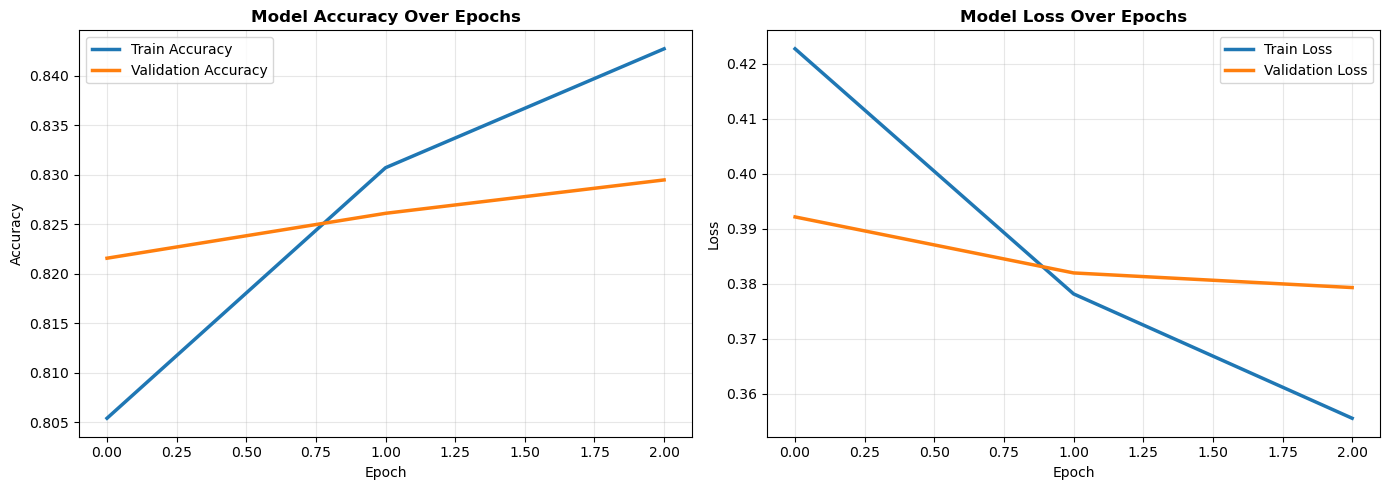

Training curves plotted successfully


In [14]:
## CELL 14: Plot Training History

plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy", linewidth=2.5)
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", linewidth=2.5)
plt.title("Model Accuracy Over Epochs", fontsize=12, fontweight='bold')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss", linewidth=2.5)
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2.5)
plt.title("Model Loss Over Epochs", fontsize=12, fontweight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Training curves plotted successfully")

In [15]:
## CELL 15: Make Predictions on Test Set

print("Making predictions on test set (this may take a few minutes)...")
y_prob = model.predict(X_test, verbose=0)
y_pred = (y_prob >= 0.5).astype(int).flatten()

print(f"✓ Predictions completed")
print(f"Predictions shape: {y_pred.shape}")
print(f"Sample predictions (first 10): {y_pred[:10]}")
print(f"Sample probabilities (first 10): {y_prob[:10].flatten()}")


Making predictions on test set (this may take a few minutes)...
✓ Predictions completed
Predictions shape: (320000,)
Sample predictions (first 10): [1 1 1 1 1 1 0 0 1 0]
Sample probabilities (first 10): [0.97213596 0.9459864  0.9064859  0.9485092  0.9775718  0.822191
 0.4341932  0.32179728 0.9391607  0.31244886]


In [16]:
## CELL 16: Classification Report

from sklearn.metrics import classification_report, confusion_matrix

print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)

report = classification_report(
    y_test, 
    y_pred, 
    target_names=['Negative', 'Positive'],
    digits=4
)
print(report)


CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative     0.8269    0.8332    0.8301    160000
    Positive     0.8319    0.8256    0.8288    160000

    accuracy                         0.8294    320000
   macro avg     0.8294    0.8294    0.8294    320000
weighted avg     0.8294    0.8294    0.8294    320000



Confusion Matrix:
[[133314  26686]
 [ 27903 132097]]


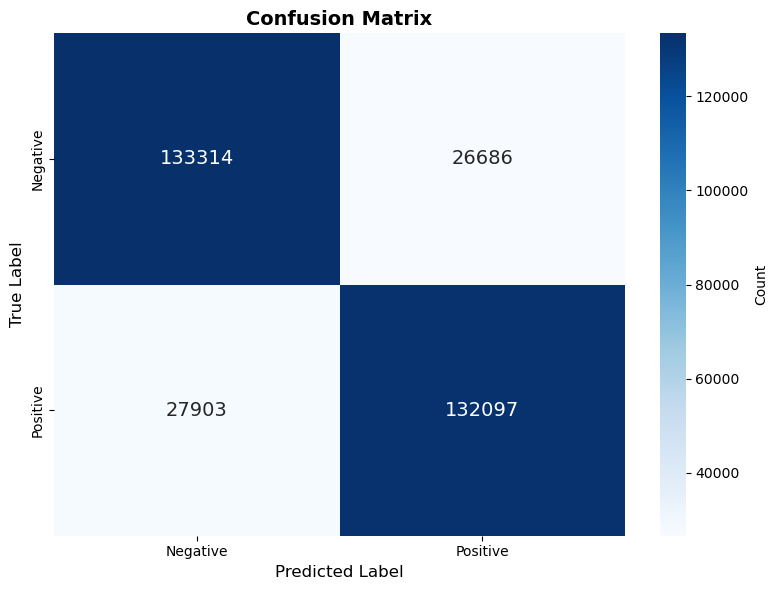

In [17]:
## CELL 17: Confusion Matrix

import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Negative', 'Positive'],
    yticklabels=['Negative', 'Positive'],
    cbar_kws={'label': 'Count'},
    annot_kws={'size': 14}
)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

In [18]:
## CELL 18: Additional Metrics

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

accuracy = (y_pred == y_test).mean()
roc_score = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("=" * 60)
print("PERFORMANCE METRICS")
print("=" * 60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_score:.4f}")
print("=" * 60)

PERFORMANCE METRICS
Accuracy:  0.8294 (82.94%)
Precision: 0.8319
Recall:    0.8256
F1-Score:  0.8288
ROC-AUC:   0.9105


In [19]:
## CELL 19: Create Prediction Function

def predict_sentiment(texts):
    """Predict sentiment for one or multiple texts"""
    if isinstance(texts, str):
        texts = [texts]
    
    X = texts_to_padded(texts, tokenizer, max_seq_length)
    proba = model.predict(X, verbose=0)
    
    results = []
    for text, prob in zip(texts, proba):
        sentiment = "POSITIVE" if prob[0] >= 0.5 else "NEGATIVE"
        confidence = max(prob[0], 1 - prob[0])
        emoji = "😊" if sentiment == "POSITIVE" else "😞"
        
        results.append({
            "text": text,
            "sentiment": sentiment,
            "confidence": float(confidence),
            "probability": float(prob[0]),
            "emoji": emoji
        })
    
    return results

print("✓ Prediction function created")


✓ Prediction function created


In [20]:
## CELL 20: Test with Sample Texts

sample_texts = [
    "I love this product! It's amazing!",
    "This is terrible and broken",
    "Not bad, but could be better",
    "Worst experience ever",
    "Absolutely fantastic!",
    "I hate this",
    "Best purchase I've made",
    "Disappointed with quality"
]

print("=" * 70)
print("SAMPLE PREDICTIONS")
print("=" * 70)

results = predict_sentiment(sample_texts)
for i, result in enumerate(results, 1):
    print(f"\n{i}. Text: {result['text']}")
    print(f"   Sentiment: {result['emoji']} {result['sentiment']}")
    print(f"   Confidence: {result['confidence']:.2%}")
    print(f"   Probability: {result['probability']:.4f}")

print("\n" + "=" * 70)

SAMPLE PREDICTIONS

1. Text: I love this product! It's amazing!
   Sentiment: 😊 POSITIVE
   Confidence: 99.36%
   Probability: 0.9936

2. Text: This is terrible and broken
   Sentiment: 😞 NEGATIVE
   Confidence: 99.05%
   Probability: 0.0095

3. Text: Not bad, but could be better
   Sentiment: 😊 POSITIVE
   Confidence: 64.70%
   Probability: 0.6470

4. Text: Worst experience ever
   Sentiment: 😞 NEGATIVE
   Confidence: 98.51%
   Probability: 0.0149

5. Text: Absolutely fantastic!
   Sentiment: 😊 POSITIVE
   Confidence: 96.43%
   Probability: 0.9643

6. Text: I hate this
   Sentiment: 😞 NEGATIVE
   Confidence: 97.91%
   Probability: 0.0209

7. Text: Best purchase I've made
   Sentiment: 😊 POSITIVE
   Confidence: 96.47%
   Probability: 0.9647

8. Text: Disappointed with quality
   Sentiment: 😞 NEGATIVE
   Confidence: 99.46%
   Probability: 0.0054



In [ ]:
## CELL 21: Create Models Directory

models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

print(f"✓ Models directory created: {os.path.abspath(models_dir)}")


✓ Models directory created: c:\Users\ASUS\python test\int_pro\Testing\models


In [22]:
## CELL 22: Save Model

model_path = os.path.join(models_dir, "sentiment_model.keras")
model.save(model_path)

print(f"✓ Model saved successfully")
print(f"Location: {os.path.abspath(model_path)}")
print(f"File size: {os.path.getsize(model_path) / (1024**2):.2f} MB")

✓ Model saved successfully
Location: c:\Users\ASUS\python test\int_pro\Testing\models\sentiment_model.keras
File size: 24.41 MB


In [23]:
## CELL 23: Save Tokenizer

tokenizer_path = os.path.join(models_dir, "tokenizer.pkl")
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)

print(f"✓ Tokenizer saved successfully")
print(f"Location: {os.path.abspath(tokenizer_path)}")
print(f"File size: {os.path.getsize(tokenizer_path) / 1024:.2f} KB")

✓ Tokenizer saved successfully
Location: c:\Users\ASUS\python test\int_pro\Testing\models\tokenizer.pkl
File size: 27316.05 KB


In [24]:
## CELL 24: Save Configuration

config = {
    "max_vocab_size": max_vocab_size,
    "max_seq_length": max_seq_length,
    "embedding_dim": embedding_dim,
    "model_version": "1.0",
    "dataset": "Sentiment140",
    "epochs_trained": epochs,
    "test_accuracy": float(accuracy),
    "roc_auc_score": float(roc_score)
}

config_path = os.path.join(models_dir, "config.pkl")
with open(config_path, 'wb') as f:
    pickle.dump(config, f)

print(f"✓ Configuration saved successfully")
print(f"Location: {os.path.abspath(config_path)}")
print(f"\nConfig contents:")
for key, value in config.items():
    print(f"  {key}: {value}")

✓ Configuration saved successfully
Location: c:\Users\ASUS\python test\int_pro\Testing\models\config.pkl

Config contents:
  max_vocab_size: 20000
  max_seq_length: 100
  embedding_dim: 100
  model_version: 1.0
  dataset: Sentiment140
  epochs_trained: 3
  test_accuracy: 0.829409375
  roc_auc_score: 0.9105045720507812


In [25]:
## CELL 25: Verify All Files

print("=" * 60)
print("VERIFICATION - All Files Saved")
print("=" * 60)

files_to_check = [
    ("sentiment_model.keras", "Model"),
    ("tokenizer.pkl", "Tokenizer"),
    ("config.pkl", "Configuration")
]

all_exist = True
for filename, description in files_to_check:
    filepath = os.path.join(models_dir, filename)
    exists = os.path.exists(filepath)
    status = "✓" if exists else "✗"
    size = f"{os.path.getsize(filepath) / 1024:.2f} KB" if exists else "N/A"
    print(f"{status} {description:12} ({filename:25}) - {size}")
    if not exists:
        all_exist = False

print("=" * 60)

if all_exist:
    print("\n✓ ALL FILES SAVED SUCCESSFULLY!")
    print("Ready to use with Streamlit app!")
else:
    print("\n✗ Some files are missing. Please check above.")

VERIFICATION - All Files Saved
✓ Model        (sentiment_model.keras    ) - 25000.09 KB
✓ Tokenizer    (tokenizer.pkl            ) - 27316.05 KB
✓ Configuration (config.pkl               ) - 0.18 KB

✓ ALL FILES SAVED SUCCESSFULLY!
Ready to use with Streamlit app!


In [ ]:
## CELL 26: Load and Test 

print("Testing model loading...")

try:
    del model
    print("✓ Previous model cleared from memory")
except NameError:
    print("ℹ No previous model in memory")

# Reload model
loaded_model = tf.keras.models.load_model(
    os.path.join(models_dir, "sentiment_model.keras")
)

# Load tokenizer
with open(os.path.join(models_dir, "tokenizer.pkl"), 'rb') as f:
    loaded_tokenizer = pickle.load(f)

# Load config
with open(os.path.join(models_dir, "config.pkl"), 'rb') as f:
    loaded_config = pickle.load(f)

print("✓ All files loaded successfully!")
print(f"\nLoaded config:")
for key, value in loaded_config.items():
    print(f"  {key}: {value}")

# Create a test prediction function using loaded model and tokenizer
def test_predict(texts):
    """Test prediction with loaded model"""
    if isinstance(texts, str):
        texts = [texts]
    
    X = texts_to_padded(texts, loaded_tokenizer, loaded_config['max_seq_length'])
    proba = loaded_model.predict(X, verbose=0)
    
    results = []
    for text, prob in zip(texts, proba):
        sentiment = "POSITIVE" if prob[0] >= 0.5 else "NEGATIVE"
        confidence = max(prob[0], 1 - prob[0])
        emoji = "😊" if sentiment == "POSITIVE" else "😞"
        
        results.append({
            "text": text,
            "sentiment": sentiment,
            "confidence": float(confidence),
            "probability": float(prob[0]),
            "emoji": emoji
        })
    
    return results

# Test prediction with loaded model
test_results = test_predict(["I love this!"])
print(f"\n✓ Test prediction successful:")
for result in test_results:
    print(f"  Text: {result['text']}")
    print(f"  Sentiment: {result['emoji']} {result['sentiment']}")
    print(f"  Confidence: {result['confidence']:.2%}")

Testing model loading...
ℹ No previous model in memory
✓ All files loaded successfully!

Loaded config:
  max_vocab_size: 20000
  max_seq_length: 100
  embedding_dim: 100
  model_version: 1.0
  dataset: Sentiment140
  epochs_trained: 3
  test_accuracy: 0.829409375
  roc_auc_score: 0.9105045720507812

✓ Test prediction successful:
  Text: I love this!
  Sentiment: 😊 POSITIVE
  Confidence: 95.59%
